In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym

# from bettermdptools.algorithms.planner import Planner
from planner import Planner
from plots import Plots

from bettermdptools.utils.test_env import TestEnv
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

from bettermdptools.utils.grid_search import GridSearch
from bettermdptools.utils.blackjack_wrapper import BlackjackWrapper
from bettermdptools.algorithms.rl import RL
import itertools

# Reward shaping

In [90]:
from gymnasium import Env
def update_rewards(env: Env, prob_move: float = None, stay_put_cost: float = -1,  move_cost: float = -0.01, goal_reward: float = 100, hole_penalty: float = -100):
    """
    Add a small penalty for each step taken
    Add a massive penalty for falling into a hole
    Add a massive reward for reaching the goal

    # This has been copied from - Michael Ardis Holley
    # https://edstem.org/us/courses/51727/discussion/4714977?answer=10894448

    Args:
        env (Env): The openAi Gym Environment
        stay_put_cost (float, optional): Penalty for staying in place. Defaults to -1.
        move_cost (float, optional): Penalty for each step taken. Defaults to -0.01.
        goal_reward (float, optional): Reward for reaching the goal. Defaults to 100.
        hole_penalty (float, optional): Penalty for falling into a hole. Defaults to -100.


    Returns:
        Env: Updated openAi Gym Environment
    """

    if prob_move is not None:
        assert 0 <= prob_move <= 1, "prob_move must be between 0 and 1"

    for k in env.P.keys():

        # For each node
        v = env.P[k]

        # For each action
        for a in v.keys():
            
            # probability, next_state, reward, done
            
            p, s, r, t = v[a][0]
            if s == k:
                # alter r for staying in-place
                r = stay_put_cost
            elif r == 1.0:
                # alter r for reaching the goal
                r = goal_reward
            elif t and r == 0.0:
                # alter r for falling into a hole
                r = hole_penalty
            else:
                # alter r for moving to another space
                r = move_cost

            if prob_move is not None:
                # update the prob of move
                p = prob_move
            
            env.P[k][a][0] = (p, s, r, t)
            
    return env



# Run the value_iteration

In [91]:
MAP_SIZE = 16 
P_FROZEN = 0.8 # Probability of tile being frozen
N_ITERS = 300
THETA = 1e-10 # Convergence threshold
GAMMA = 0.9 # Discount factor
RANDOM_SEED = 42
IS_SLIPPERY = False

In [92]:
# Test graph
desc = ['SFFFHHHFFFFFFFFF',
 'FHHFFFFFFFHFHFFF',
 'FFHFHFFFFFFFFFFF',
 'FFFHFFFFFFFFFFHH',
 'FFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFF',
 'FFFFFFFHFFFFFFFH',
 'FFFFHFFFFFFFFFFF',
 'FHFFFFFFHFFHFFFF',
 'HHFFHFFFHFFFHFFH',
 'HFHHFFFFFFFHFHFF',
 'FFHFFHFHHFHFFFFF',
 'FFFFFFFFFFFHFFFH',
 'FHFHFFFFFHFFFFFF',
 'FHHFFHFFFFFFFHFF',
 'FFFFFHFFHFFHHFFG']

In [93]:

# frozen_lake = gym.make('FrozenLake-v1', desc=generate_random_map(size=MAP_SIZE, p=P_FROZEN), is_slippery=IS_SLIPPERY, render_mode="rgb_array")
frozen_lake = gym.make('FrozenLake-v1', desc=desc, is_slippery=IS_SLIPPERY, render_mode="human")

# frozen_lake = update_rewards(frozen_lake)

# reset the map first
s_0, info = frozen_lake.reset(seed=RANDOM_SEED)

# run VI
V, V_track, pi, n_i = Planner(frozen_lake.P).value_iteration(gamma=GAMMA, n_iters=N_ITERS, theta=THETA)

# V is the final value
# V_track is the value of each state at each iteration
# pi is the final policy - mapping states to actions

print(f"n_i : {n_i}")


runtime = 0.02 seconds
n_i : 31


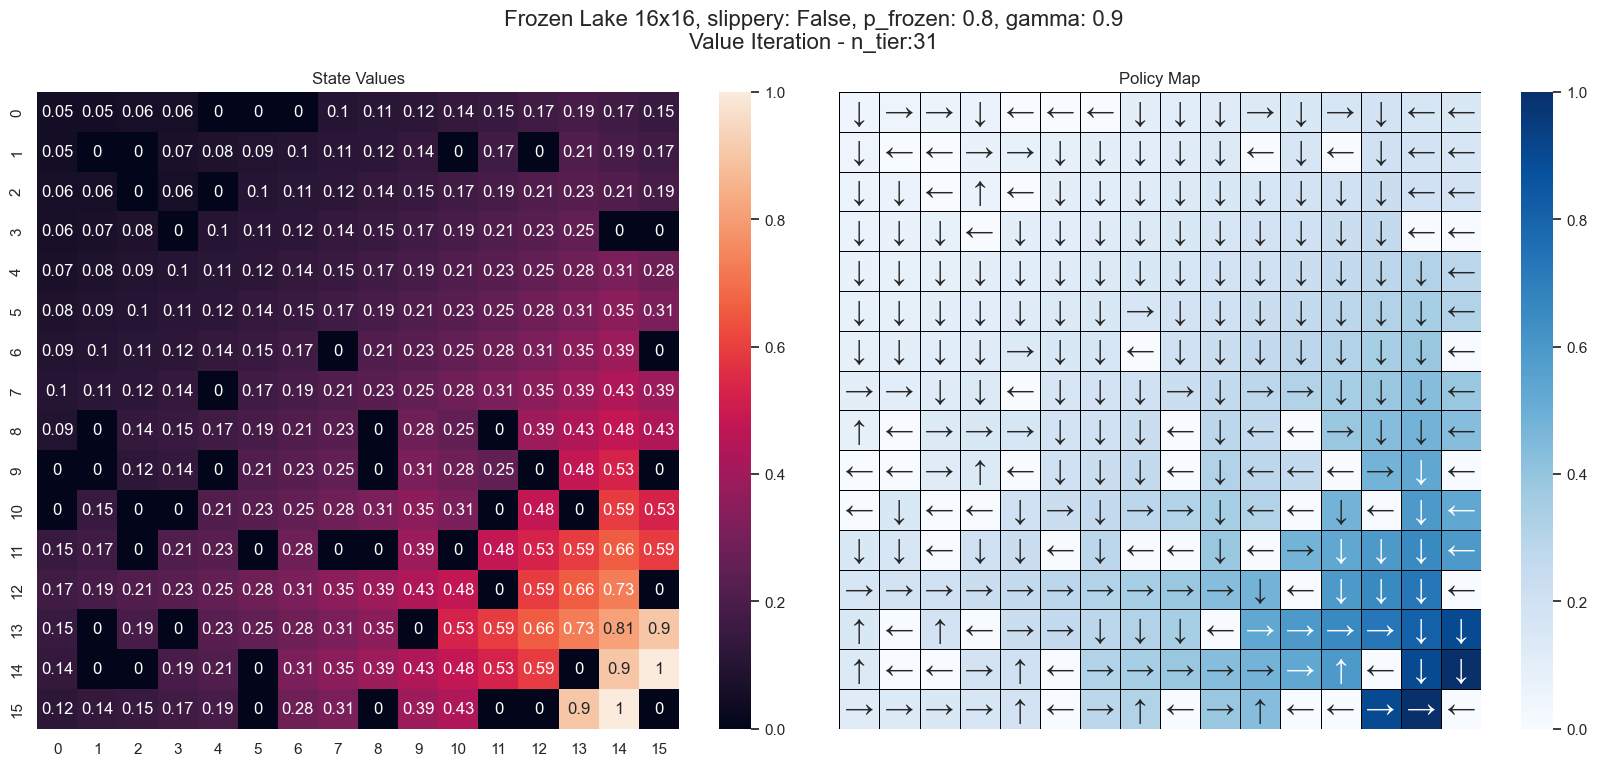

In [94]:
# plot state values
sns.set_theme(rc={'figure.figsize':(20.7,8.27)})

fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(wspace=0, hspace=0)

size=(MAP_SIZE, MAP_SIZE)

Plots.values_heat_map(V, "State Values", size, ax[0])

v_max, directions = Plots.get_policy_map(pi, V, {0: "←", 1: "↓", 2: "→", 3: "↑"}, size)

Plots.plot_policy(v_max, directions=directions, title='Policy Map', ax=ax[1])

fig.suptitle(f'Frozen Lake {MAP_SIZE}x{MAP_SIZE}, slippery: {IS_SLIPPERY}, p_frozen: {P_FROZEN}, gamma: {GAMMA}\nValue Iteration - n_tier:{n_i}', fontsize=16);


## Value Iter - Update the rewards

In [106]:

# frozen_lake = gym.make('FrozenLake-v1', desc=generate_random_map(size=MAP_SIZE, p=P_FROZEN), is_slippery=IS_SLIPPERY, render_mode="rgb_array")
frozen_lake = gym.make('FrozenLake-v1', desc=desc, is_slippery=IS_SLIPPERY, render_mode="human")

frozen_lake = update_rewards(frozen_lake, prob_move=1,  move_cost=-0.1, stay_put_cost=0.0, goal_reward=10, hole_penalty=-10)

# reset the map first
s_0, info = frozen_lake.reset(seed=RANDOM_SEED)

# run VI
V, V_track, pi, n_i = Planner(frozen_lake.P).value_iteration(gamma=GAMMA, n_iters=N_ITERS, theta=THETA)

# V is the final value
# V_track is the value of each state at each iteration
# pi is the final policy - mapping states to actions

print(f"n_i : {n_i}")

runtime = 0.03 seconds
n_i : 26


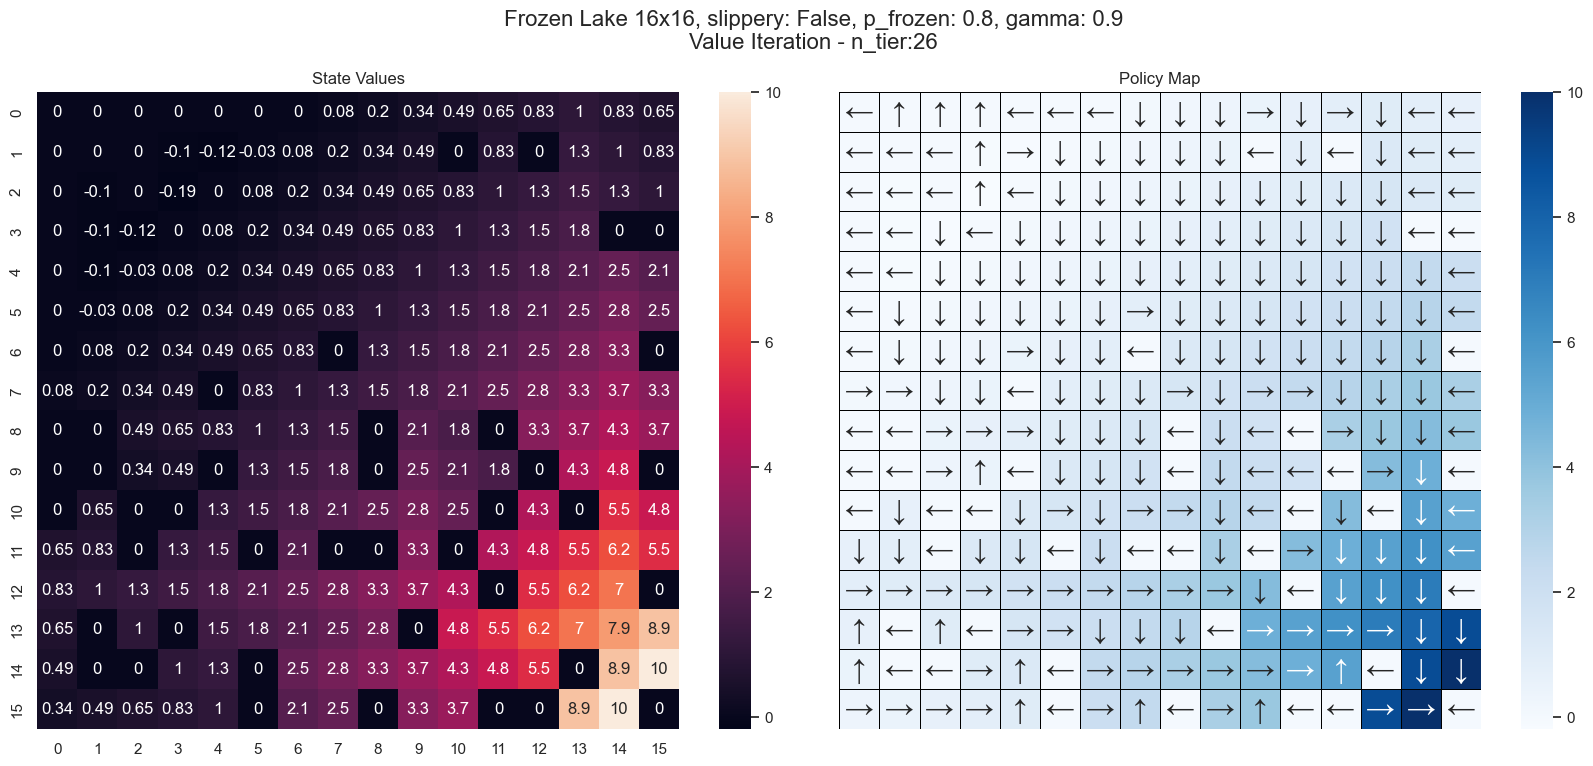

In [107]:
# plot state values
sns.set_theme(rc={'figure.figsize':(20.7,8.27)})

fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(wspace=0, hspace=0)

size=(MAP_SIZE, MAP_SIZE)

Plots.values_heat_map(V, "State Values", size, ax[0])

v_max, directions = Plots.get_policy_map(pi, V, {0: "←", 1: "↓", 2: "→", 3: "↑"}, size)

Plots.plot_policy(v_max, directions=directions, title='Policy Map', ax=ax[1])

fig.suptitle(f'Frozen Lake {MAP_SIZE}x{MAP_SIZE}, slippery: {IS_SLIPPERY}, p_frozen: {P_FROZEN}, gamma: {GAMMA}\nValue Iteration - n_tier:{n_i}', fontsize=16);



# Run policy_iteration

In [88]:
# frozen_lake = gym.make('FrozenLake-v1', desc=generate_random_map(size=MAP_SIZE, p=P_FROZEN), is_slippery=IS_SLIPPERY, render_mode="rgb_array")
frozen_lake = gym.make('FrozenLake-v1', desc=desc, is_slippery=IS_SLIPPERY, render_mode="human")

# frozen_lake = update_rewards(frozen_lake, move_cost=-0.01, stay_put_cost=-0.0, goal_reward=10, hole_penalty=-10)

# reset the map first
s_0, info = frozen_lake.reset(seed=RANDOM_SEED)

# run VI
V, V_track, pi, n_i = Planner(frozen_lake.P).policy_iteration(gamma=GAMMA, n_iters=N_ITERS, theta=THETA)

# V is the final value
# V_track is the value of each state at each iteration
# pi is the final policy - mapping states to actions

print(f"n_i : {n_i}")

runtime = 0.03 seconds
n_i : 31


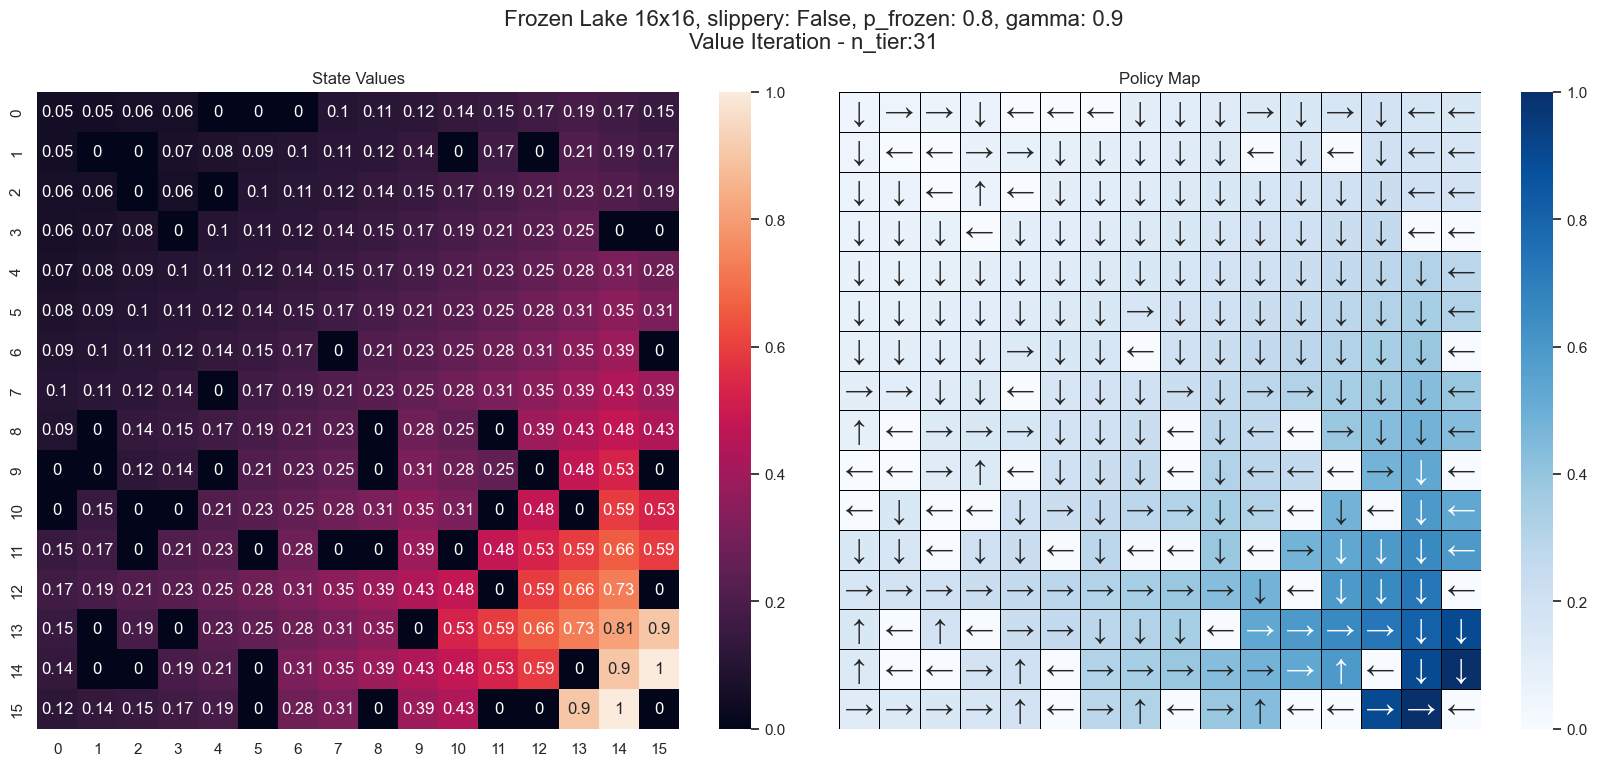

In [89]:
# plot state values
sns.set_theme(rc={'figure.figsize':(20.7,8.27)})

fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(wspace=0, hspace=0)

size=(MAP_SIZE, MAP_SIZE)

Plots.values_heat_map(V, "State Values", size, ax[0])

v_max, directions = Plots.get_policy_map(pi, V, {0: "←", 1: "↓", 2: "→", 3: "↑"}, size)

Plots.plot_policy(v_max, directions=directions, title='Policy Map', ax=ax[1])

fig.suptitle(f'Frozen Lake {MAP_SIZE}x{MAP_SIZE}, slippery: {IS_SLIPPERY}, p_frozen: {P_FROZEN}, gamma: {GAMMA}\Policy Iteration - n_tier:{n_i}', fontsize=16);



## Policy Iter - Update the rewards

In [ ]:
# frozen_lake = gym.make('FrozenLake-v1', desc=generate_random_map(size=MAP_SIZE, p=P_FROZEN), is_slippery=IS_SLIPPERY, render_mode="rgb_array")
frozen_lake = gym.make('FrozenLake-v1', desc=desc, is_slippery=IS_SLIPPERY, render_mode="human")

# frozen_lake = update_rewards(frozen_lake, move_cost=-0.01, stay_put_cost=-0.0, goal_reward=10, hole_penalty=-10)

# reset the map first
s_0, info = frozen_lake.reset(seed=RANDOM_SEED)

# run VI
V, V_track, pi, n_i = Planner(frozen_lake.P).policy_iteration(gamma=GAMMA, n_iters=N_ITERS, theta=THETA)

# V is the final value
# V_track is the value of each state at each iteration
# pi is the final policy - mapping states to actions

print(f"n_i : {n_i}")

In [ ]:
# plot state values
sns.set_theme(rc={'figure.figsize':(20.7,8.27)})

fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(wspace=0, hspace=0)

size=(MAP_SIZE, MAP_SIZE)

Plots.values_heat_map(V, "State Values", size, ax[0])

v_max, directions = Plots.get_policy_map(pi, V, {0: "←", 1: "↓", 2: "→", 3: "↑"}, size)

Plots.plot_policy(v_max, directions=directions, title='Policy Map', ax=ax[1])

fig.suptitle(f'Frozen Lake {MAP_SIZE}x{MAP_SIZE}, slippery: {IS_SLIPPERY}, p_frozen: {P_FROZEN}, gamma: {GAMMA}\Policy Iteration - n_tier:{n_i}', fontsize=16);



# Value iteration - Grid

In [ ]:
MAP_SIZE = 10 
P_FROZEN = 0. # Probability of tile being frozen
N_ITERS = 100
THETA = 1e-10 # Convergence threshold
GAMMA = 0.9 # Discount factor
RANDOM_SEED = 42

In [ ]:
frozen_lake = gym.make('FrozenLake-v1', desc=generate_random_map(size=MAP_SIZE, p=P_FROZEN), is_slippery=False, render_mode="rgb_array")

# reset the map first
s_0, info = frozen_lake.reset(seed=RANDOM_SEED)

# run VI
# V, V_track, pi = Planner(frozen_lake.P).value_iteration(gamma=GAMMA, n_iters=N_ITERS, theta=THETA)

In [ ]:
map_sizes = [16, 20]
p_frozen_values = [0.8, 0.9]
gamma_values = [0.9, 0.95]
n_iters_values = [100, 1000]
theta_values = [1e-10, 1e-3]

for grid_params in itertools.product(map_sizes, p_frozen_values, gamma_values, n_iters_values, theta_values):

    map_size, p_frozen, gamma, n_iters, theta = grid_params

    print(f"Running PI with map_size: {map_size}, p+frozen: {p_frozen}, gamma: {gamma},  n_iters:{n_iters}, theta:{theta}")
    
    env = gym.make('FrozenLake-v1', desc=generate_random_map(size=map_size, p=p_frozen), is_slippery=True)
    env.reset(seed=RANDOM_SEED)

    V, V_track, pi, n_i = Planner(env.P).policy_iteration(gamma=gamma, n_iters=n_iters, theta=theta)

    episode_rewards = TestEnv.test_env(env=env, n_iters=100, pi=pi)

    print("Avg. episode reward: ", np.mean(episode_rewards))
    print("###################")

In [ ]:
episode_rewards

In [ ]:
env.reset(seed=RANDOM_SEED)

V, V_track, pi = Planner(env.P).policy_iteration(gamma=gamma, n_iters=n_iters, theta=theta)

In [ ]:
V_track.mean(axis=1)

In [ ]:
V_track[24, :]